In [74]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
import time
import pickle

import re
import nltk

import tensorflow as tf

from datetime import datetime
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from gensim.models import Word2Vec, FastText





warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.19.0


In [75]:
# Load the dataset

SAMPLE_SIZE = 50000 
print(f"Loading dataset (sample_size={SAMPLE_SIZE})...")
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', nrows=SAMPLE_SIZE)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset (sample_size=50000)...

Dataset loaded successfully!
Shape: (50000, 10)
Memory usage: 37.06 MB


In [76]:
# Display basic information
print("Dataset Info:")
print("="*80)
df.info()

print("\n" + "="*80)
print("First few rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49995 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49998 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB

First few rows:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...


In [77]:
# Column descriptions
print("Column Descriptions:")
print("="*80)
print("Id:                     Unique review identifier")
print("ProductId:              Amazon product identifier")
print("UserId:                 Reviewer's user ID")
print("ProfileName:            Reviewer's display name")
print("HelpfulnessNumerator:   Number of users who found review helpful")
print("HelpfulnessDenominator: Total number of helpfulness votes")
print("Score:                  Rating (1-5 stars) - TARGET VARIABLE")
print("Time:                   Unix timestamp of review")
print("Summary:                Review title/summary text")
print("Text:                   Full review text - PRIMARY TEXT FIELD")

Column Descriptions:
Id:                     Unique review identifier
ProductId:              Amazon product identifier
UserId:                 Reviewer's user ID
ProfileName:            Reviewer's display name
HelpfulnessNumerator:   Number of users who found review helpful
HelpfulnessDenominator: Total number of helpfulness votes
Score:                  Rating (1-5 stars) - TARGET VARIABLE
Time:                   Unix timestamp of review
Summary:                Review title/summary text
Text:                   Full review text - PRIMARY TEXT FIELD


In [78]:
# Statistical summary
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04
mean,25000.500000,1.603360,2.060260,4.145840,1.295198e+09
std,14433.901067,5.620771,6.216044,1.325596,4.734622e+07
min,1.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,12500.750000,0.000000,0.000000,4.000000,1.269648e+09
50%,25000.500000,0.000000,1.000000,5.000000,1.309133e+09
75%,37500.250000,2.000000,2.000000,5.000000,1.331078e+09
max,50000.000000,398.000000,401.000000,5.000000,1.351210e+09


In [79]:
# Check for missing values
print("Missing Values:")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")

# Check for duplicates
print(f"\n\nDuplicate rows: {df.duplicated().sum()}")
print(f"Duplicate IDs: {df['Id'].duplicated().sum()}")

Missing Values:
     Column  Missing Count  Percentage
ProfileName              5       0.010
    Summary              2       0.004


Duplicate rows: 0
Duplicate IDs: 0


In [80]:
# Score distribution
score_dist = df['Score'].value_counts().sort_index()

print("Rating Score Distribution:")
print("="*80)
for score, count in score_dist.items():
    pct = (count / len(df)) * 100
    print(f"Score {score}: {count:>8} ({pct:>5.2f}%)")

print(f"\nTotal reviews: {len(df)}")

Rating Score Distribution:
Score 1:     4721 ( 9.44%)
Score 2:     2814 ( 5.63%)
Score 3:     4047 ( 8.09%)
Score 4:     7288 (14.58%)
Score 5:    31130 (62.26%)

Total reviews: 50000


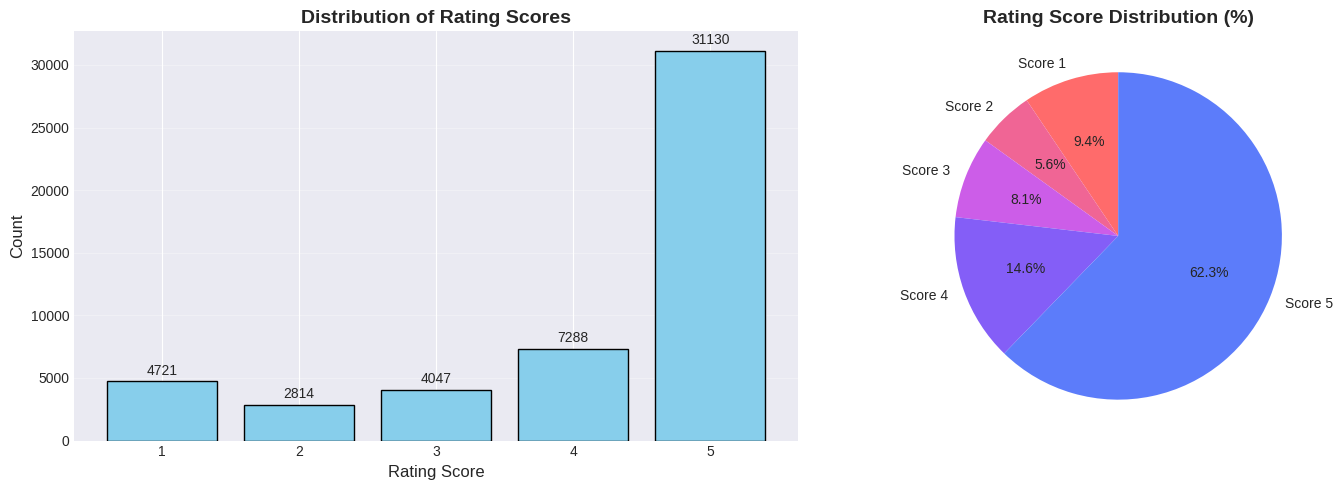


📊 Key Observation: Dataset is IMBALANCED - heavily skewed toward positive reviews (scores 4-5)


In [81]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(score_dist.index, score_dist.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Rating Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Rating Scores', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(score_dist.values):
    axes[0].text(score_dist.index[i], v + max(score_dist.values)*0.01, 
                str(v), ha='center', va='bottom')

# Pie chart
colors = ['#ff6b6b', '#f06595', '#cc5de8', '#845ef7', '#5c7cfa']
axes[1].pie(score_dist.values, labels=[f'Score {s}' for s in score_dist.index],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Rating Score Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Observation: Dataset is IMBALANCED - heavily skewed toward positive reviews (scores 4-5)")

In [82]:
# Calculate text statistics
df['text_length'] = df['Text'].fillna('').apply(len)
df['word_count'] = df['Text'].fillna('').apply(lambda x: len(x.split()))
df['summary_length'] = df['Summary'].fillna('').apply(len)
df['summary_word_count'] = df['Summary'].fillna('').apply(lambda x: len(x.split()))

# Display statistics
print("Text Length Statistics:")
print("="*80)
print("\nReview Text:")
print(df['text_length'].describe())
print(f"\nWord Count:")
print(df['word_count'].describe())

print("\n\nSummary:")
print(df['summary_length'].describe())
print(f"\nSummary Word Count:")
print(df['summary_word_count'].describe())

Text Length Statistics:

Review Text:
count    50000.000000
mean       431.196380
std        423.378362
min         33.000000
25%        180.000000
50%        303.000000
75%        524.000000
max      10327.000000
Name: text_length, dtype: float64

Word Count:
count    50000.000000
mean        79.383860
std         75.430186
min          6.000000
25%         34.000000
50%         57.000000
75%         97.000000
max       1751.000000
Name: word_count, dtype: float64


Summary:
count    50000.000000
mean        23.372700
std         13.944388
min          0.000000
25%         13.000000
50%         20.000000
75%         30.000000
max        128.000000
Name: summary_length, dtype: float64

Summary Word Count:
count    50000.000000
mean         4.106140
std          2.589218
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         31.000000
Name: summary_word_count, dtype: float64


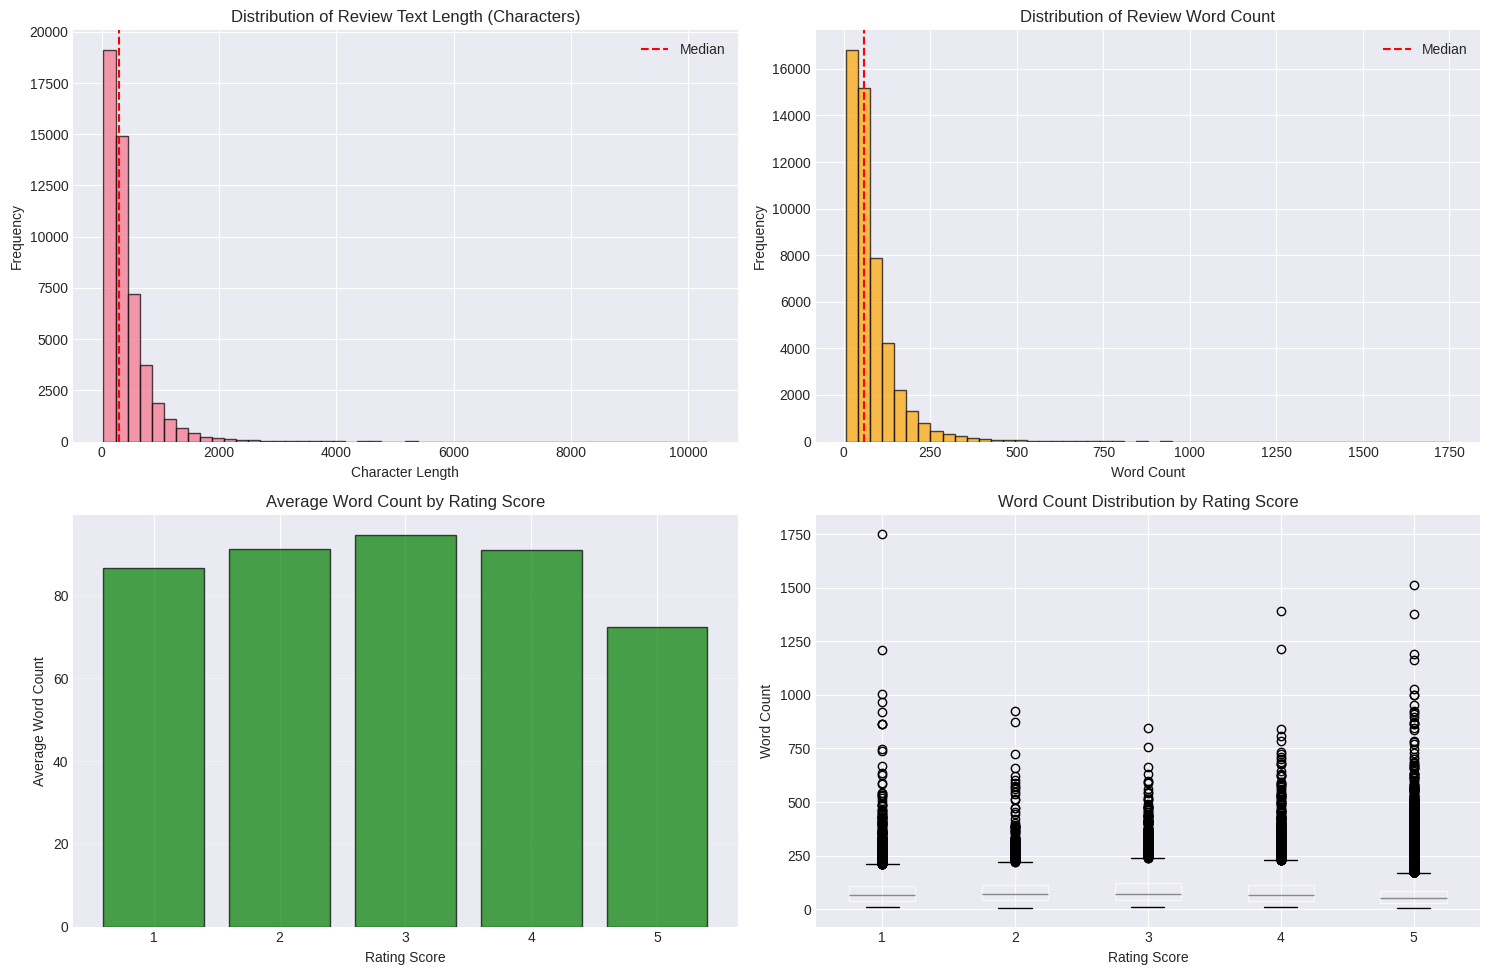

In [83]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length histogram
axes[0, 0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Review Text Length (Characters)')
axes[0, 0].axvline(df['text_length'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# Word count histogram
axes[0, 1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Review Word Count')
axes[0, 1].axvline(df['word_count'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# Word count by score
score_groups = df.groupby('Score')['word_count'].mean().sort_index()
axes[1, 0].bar(score_groups.index, score_groups.values, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Rating Score')
axes[1, 0].set_ylabel('Average Word Count')
axes[1, 0].set_title('Average Word Count by Rating Score')
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plot of word count by score
df.boxplot(column='word_count', by='Score', ax=axes[1, 1])
axes[1, 1].set_xlabel('Rating Score')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].set_title('Word Count Distribution by Rating Score')
axes[1, 1].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [84]:
# Display sample reviews for each score
print("Sample Reviews for Each Rating Score:")
print("="*100)

for score in sorted(df['Score'].unique()):
    print(f"\n{'='*100}")
    print(f"Score {score} - Sample Reviews:")
    print(f"{'='*100}")
    
    samples = df[df['Score'] == score].sample(min(2, len(df[df['Score'] == score])))
    
    for idx, row in samples.iterrows():
        print(f"\nSummary: {row['Summary']}")
        print(f"Text: {row['Text'][:300]}...")  # Show first 300 characters
        print("-" * 100)

Sample Reviews for Each Rating Score:

Score 1 - Sample Reviews:

Summary: Crushed bay leave for a baby?
Text: Nobody eats a bay leaf. It can be quite irritating for the stomach. Bay leaf is added just for flavor and then is usually removed before the food is served. So I am not sure I understand why they added so much crushed bay leaf into something that is prepared for babies. I am not buying this anymore....
----------------------------------------------------------------------------------------------------

Summary: Tastes like chewing tobacco
Text: I thought maybe a disgruntled employee dumped a can of Copenhagen chewing tobacco into the mix. I spit this out of my mouth it was SO bad...
----------------------------------------------------------------------------------------------------

Score 2 - Sample Reviews:

Summary: Great Taste - Poor Packaging
Text: I purchased packs of 12 o four different flavors of these breadsticks. I was very disappointed when I received them. Two of th

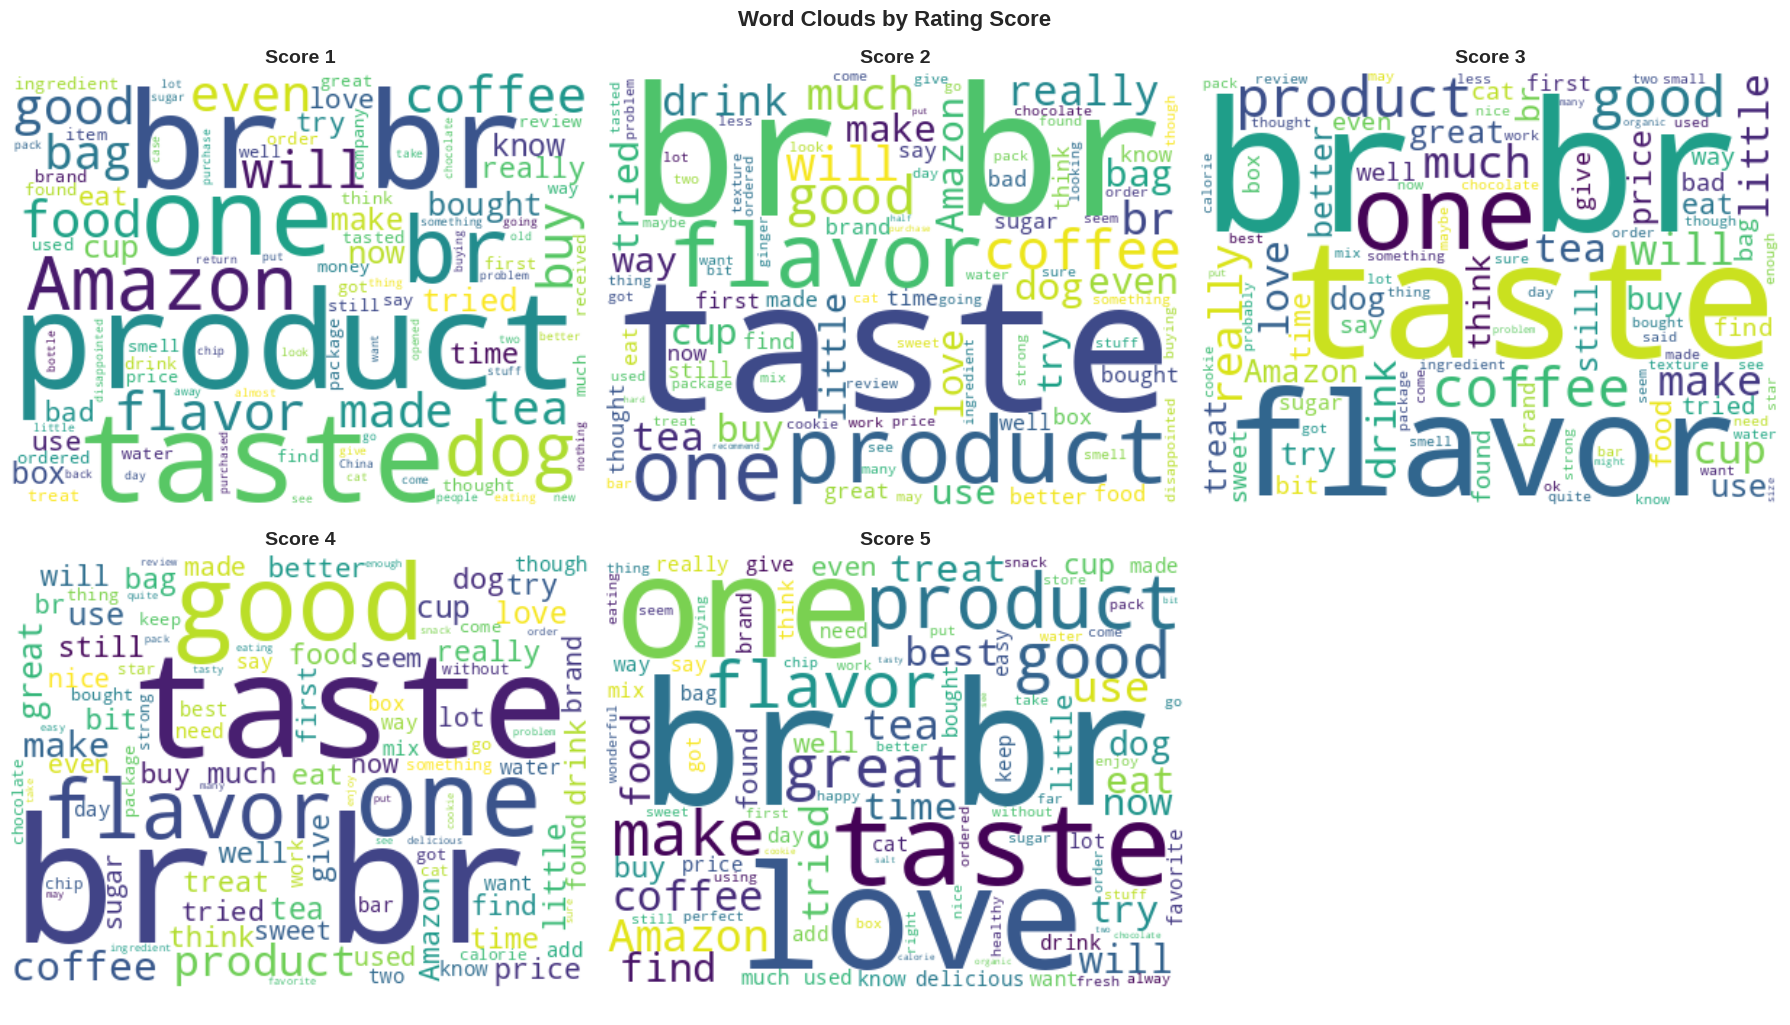

In [86]:
# Generate word clouds for different scores
from collections import Counter

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, score in enumerate([1, 2, 3, 4, 5]):
    # Get all text for this score
    score_text = ' '.join(df[df['Score'] == score]['Text'].fillna('').values)
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(score_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Score {score}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Word Clouds by Rating Score', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [87]:
# Download required NLTK data
import nltk
print("Downloading required NLTK data...")
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK data downloaded successfully!")

# Simple preprocessing demonstration without external modules
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def simple_preprocess(text):
    """Simple text preprocessing function"""
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Demonstrate preprocessing on a sample review
sample_idx = df[df['Score'] == 5].iloc[0]
sample_text = sample_idx['Text']

print("\nOriginal Text:")
print("="*100)
print(sample_text)

print("\n\nPreprocessed Text (as tokens):")
print("="*100)
processed_tokens = simple_preprocess(sample_text)
print(processed_tokens)

print("\n\nPreprocessed Text (as string):")
print("="*100)
processed_string = ' '.join(processed_tokens)
print(processed_string)

NLTK data downloaded successfully!

Original Text:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Preprocessed Text (as tokens):
['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'product', 'found', 'good', 'quality', 'product', 'look', 'like', 'stew', 'processed', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Preprocessed Text (as string):
bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better


In [88]:
# Demonstrate data splitting strategy
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Use a smaller sample for demonstration
demo_df = df.sample(n=10000, random_state=42)

print(f"Demo dataset shape: {demo_df.shape}")
print(f"\nClass distribution:")
print(demo_df['Score'].value_counts().sort_index())

# Perform stratified split
# First split: train + temp (80%) and test (20%)
train_temp, test_df = train_test_split(
    demo_df, 
    test_size=0.2, 
    stratify=demo_df['Score'],
    random_state=42
)

# Second split: train (72%) and validation (8% of original, 10% of train_temp)
train_df, val_df = train_test_split(
    train_temp,
    test_size=0.1,
    stratify=train_temp['Score'],
    random_state=42
)

print(f"\nTrain set: {len(train_df)} samples ({len(train_df)/len(demo_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(demo_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(demo_df)*100:.1f}%)")

# Compute class weights for handling imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Score']),
    y=train_df['Score']
)

class_weight_dict = dict(zip(np.unique(train_df['Score']), class_weights))
print(f"\nClass weights for handling imbalance:")
for score, weight in class_weight_dict.items():
    print(f"  Score {score}: {weight:.3f}")

print("\n✓ Data splitting demonstration complete!")

Demo dataset shape: (10000, 14)

Class distribution:
Score
1     946
2     599
3     838
4    1454
5    6163
Name: count, dtype: int64

Train set: 7200 samples (72.0%)
Validation set: 800 samples (8.0%)
Test set: 2000 samples (20.0%)

Class weights for handling imbalance:
  Score 1: 2.115
  Score 2: 3.341
  Score 3: 2.384
  Score 4: 1.375
  Score 5: 0.325

✓ Data splitting demonstration complete!


In [89]:
# Text Preprocessing Class
class TextPreprocessor:
    """Comprehensive text preprocessing pipeline."""
    
    def __init__(self, remove_stopwords=True, lemmatize=True):
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
    
    def remove_html_tags(self, text):
        """Remove HTML tags using BeautifulSoup."""
        if pd.isna(text):
            return ""
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    def clean_text(self, text):
        """Clean and normalize text."""
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text, return_string=False):
        """Complete preprocessing pipeline."""
        # Remove HTML
        text = self.remove_html_tags(text)
        # Clean
        text = self.clean_text(text)
        # Lowercase
        text = text.lower()
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]
        # Lemmatize
        if self.lemmatize and self.lemmatizer:
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        # Filter short tokens
        tokens = [t for t in tokens if len(t) >= 2]
        
        return ' '.join(tokens) if return_string else tokens

print("✅ TextPreprocessor class defined")

✅ TextPreprocessor class defined


Model Training Section

In [90]:
# Training Configuration
TRAIN_CONFIG = {
    # Data settings
    'DATA_PATH': '/kaggle/input/amazon-fine-food-reviews/Reviews.csv',
    'SAMPLE_SIZE': 20000,  
    'TEST_SIZE': 0.2,
    'VAL_SIZE': 0.1,
    'RANDOM_STATE': 42,
    
    # Text preprocessing
    'MAX_SEQUENCE_LENGTH': 128,  
    'MIN_WORD_FREQ': 2,
    'MAX_VOCAB_SIZE': 50000,
    
    # Model hyperparameters
    'NUM_CLASSES': 5,
    'BATCH_SIZE': 128, 
    'EPOCHS': 30,
    'LEARNING_RATE': 0.001,
    
    # GRU architecture (optimized)
    'GRU_UNITS': 96, 
    'DROPOUT_RATE': 0.3, 
    'RECURRENT_DROPOUT': 0.1,  
    'USE_BIDIRECTIONAL': True,
    'NUM_GRU_LAYERS': 1, 
    # Embedding dimensions
    'EMBEDDING_DIM': 100,
    'TFIDF_MAX_FEATURES': 5000,
    
    # Training
    'EARLY_STOPPING_PATIENCE': 7,
    'REDUCE_LR_PATIENCE': 3,
    'USE_CLASS_WEIGHTS': True,
}

# Create directories for saving results
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)
os.makedirs('../results/plots', exist_ok=True)

print("✅ Training configuration loaded:")
print(f"  Sample size: {TRAIN_CONFIG['SAMPLE_SIZE']}")
print(f"  Max sequence length: {TRAIN_CONFIG['MAX_SEQUENCE_LENGTH']}")
print(f"  GRU units: {TRAIN_CONFIG['GRU_UNITS']}")
print(f"  Batch size: {TRAIN_CONFIG['BATCH_SIZE']}")
print(f"  Epochs: {TRAIN_CONFIG['EPOCHS']}")

✅ Training configuration loaded:
  Sample size: 20000
  Max sequence length: 128
  GRU units: 96
  Batch size: 128
  Epochs: 30


In [91]:
def load_and_split_data(config):
    """Load data and perform stratified split."""
    print(f"📂 Loading data from {config['DATA_PATH']}...")
    
    # Load dataset
    if config['SAMPLE_SIZE']:
        df = pd.read_csv(config['DATA_PATH'], nrows=config['SAMPLE_SIZE'])
    else:
        df = pd.read_csv(config['DATA_PATH'])
    
    print(f"  Loaded {len(df):,} reviews")

    # Select relevant columns
    df = df[['Text', 'Score']].copy()
    
    # Remove missing values
    df.dropna(inplace=True)
    print(f"  After removing NaN: {len(df):,} reviews")
    
    # Convert Score to 0-indexed (0-4 instead of 1-5)
    df['Score'] = df['Score'] - 1
    
    # Stratified split: train+temp (80%) and test (20%)
    train_temp, test_df = train_test_split(
        df,
        test_size=config['TEST_SIZE'],
        stratify=df['Score'],
        random_state=config['RANDOM_STATE']
    )
    
    # Split train_temp into train and validation
    val_size = config['VAL_SIZE'] / (1 - config['TEST_SIZE'])
    train_df, val_df = train_test_split(
        train_temp,
        test_size=val_size,
        stratify=train_temp['Score'],
        random_state=config['RANDOM_STATE']
    )
    
    print(f"\n📊 Dataset split:")
    print(f"  Training: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"  Validation: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
    
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['Score']),
        y=train_df['Score']
    )
    class_weight_dict = dict(zip(np.unique(train_df['Score']), class_weights))
    
    print(f"\n⚖️ Class weights (to handle imbalance):")
    for cls, weight in class_weight_dict.items():
        print(f"  Class {cls}: {weight:.3f}")
    
    return train_df, val_df, test_df, class_weight_dict

In [92]:

    

def preprocess_texts(texts, preprocessor, return_string=True):
    """Preprocess a list of texts."""
    processed = []
    for text in texts:
        processed.append(preprocessor.preprocess_text(text, return_string=return_string))
    return processed

print("✅ Data loading functions defined")

✅ Data loading functions defined


In [93]:
class EmbeddingGenerator:
    """Generate different types of embeddings for text classification."""
    
    def __init__(self, config):
        self.config = config
        self.tokenizer = None
        self.word_index = None
        self.embedding_matrix = None
        
    def generate_tfidf(self, train_texts, val_texts, test_texts):
        """Generate TF-IDF features."""
        print("\n🔤 Generating TF-IDF embeddings...")
        
        vectorizer = TfidfVectorizer(
            max_features=self.config['TFIDF_MAX_FEATURES'],
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        
        X_train = vectorizer.fit_transform(train_texts).toarray()
        X_val = vectorizer.transform(val_texts).toarray()
        X_test = vectorizer.transform(test_texts).toarray()
        
        print(f"  Feature dimensions: {X_train.shape[1]}")
        print(f"  Train shape: {X_train.shape}")
        print(f"  Val shape: {X_val.shape}")
        print(f"  Test shape: {X_test.shape}")
        
        return X_train, X_val, X_test, vectorizer
    
    def generate_word2vec(self, train_texts, val_texts, test_texts, sg=0):
        """Generate Word2Vec embeddings (sg=0 for CBOW, sg=1 for Skip-gram)."""
        model_type = "CBOW" if sg == 0 else "Skip-gram"
        print(f"\n🔤 Generating Word2Vec {model_type} embeddings...")
        
        # Tokenize texts into list of words
        train_tokens = [text.split() for text in train_texts]
        val_tokens = [text.split() for text in val_texts]
        test_tokens = [text.split() for text in test_texts]
        
        # Train Word2Vec model
        print(f"  Training Word2Vec {model_type}...")
        w2v_model = Word2Vec(
            sentences=train_tokens,
            vector_size=self.config['EMBEDDING_DIM'],
            window=5,
            min_count=self.config['MIN_WORD_FREQ'],
            workers=4,
            sg=sg,
            epochs=10,
            seed=self.config['RANDOM_STATE']
        )
        
        # Build vocabulary and word index
        word_vectors = w2v_model.wv
        vocab_size = len(word_vectors) + 2  # +2 for padding and OOV
        
        # Create word index
        word_index = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
        word_index['<PAD>'] = 0
        word_index['<OOV>'] = vocab_size - 1
        
        # Create embedding matrix
        embedding_matrix = np.zeros((vocab_size, self.config['EMBEDDING_DIM']))
        for word, idx in word_index.items():
            if word in word_vectors:
                embedding_matrix[idx] = word_vectors[word]
            elif word == '<OOV>':
                embedding_matrix[idx] = np.random.normal(0, 0.1, self.config['EMBEDDING_DIM'])
        
        # Convert texts to sequences
        X_train = self._texts_to_sequences(train_tokens, word_index)
        X_val = self._texts_to_sequences(val_tokens, word_index)
        X_test = self._texts_to_sequences(test_tokens, word_index)
        
        print(f"  Vocabulary size: {vocab_size}")
        print(f"  Embedding dimension: {self.config['EMBEDDING_DIM']}")
        print(f"  Train shape: {X_train.shape}")
        print(f"  Val shape: {X_val.shape}")
        print(f"  Test shape: {X_test.shape}")
        
        self.word_index = word_index
        self.embedding_matrix = embedding_matrix
        
        return X_train, X_val, X_test, embedding_matrix, vocab_size
    
    def generate_fasttext(self, train_texts, val_texts, test_texts):
        """Generate FastText embeddings."""
        print("\n🔤 Generating FastText embeddings...")
        
        # Tokenize texts
        train_tokens = [text.split() for text in train_texts]
        val_tokens = [text.split() for text in val_texts]
        test_tokens = [text.split() for text in test_texts]
        
        # Train FastText model
        print("  Training FastText...")
        ft_model = FastText(
            sentences=train_tokens,
            vector_size=self.config['EMBEDDING_DIM'],
            window=5,
            min_count=self.config['MIN_WORD_FREQ'],
            workers=4,
            sg=1,  # Skip-gram
            min_n=3,  # Min character n-gram
            max_n=6,  # Max character n-gram
            epochs=10,
            seed=self.config['RANDOM_STATE']
        )
        
        # Build vocabulary and word index
        word_vectors = ft_model.wv
        vocab_size = len(word_vectors) + 2
        
        # Create word index
        word_index = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
        word_index['<PAD>'] = 0
        word_index['<OOV>'] = vocab_size - 1
        
        # Create embedding matrix
        embedding_matrix = np.zeros((vocab_size, self.config['EMBEDDING_DIM']))
        for word, idx in word_index.items():
            if word in word_vectors:
                embedding_matrix[idx] = word_vectors[word]
            elif word == '<OOV>':
                embedding_matrix[idx] = np.random.normal(0, 0.1, self.config['EMBEDDING_DIM'])
        
        # Convert texts to sequences
        X_train = self._texts_to_sequences(train_tokens, word_index)
        X_val = self._texts_to_sequences(val_tokens, word_index)
        X_test = self._texts_to_sequences(test_tokens, word_index)
        
        print(f"  Vocabulary size: {vocab_size}")
        print(f"  Embedding dimension: {self.config['EMBEDDING_DIM']}")
        print(f"  Train shape: {X_train.shape}")
        
        self.word_index = word_index
        self.embedding_matrix = embedding_matrix
        
        return X_train, X_val, X_test, embedding_matrix, vocab_size
    
    def _texts_to_sequences(self, token_lists, word_index):
        """Convert tokenized texts to padded sequences."""
        sequences = []
        oov_idx = len(word_index) - 1
        
        for tokens in token_lists:
            seq = [word_index.get(word, oov_idx) for word in tokens]
            sequences.append(seq)
        
        # Pad sequences
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        padded = pad_sequences(
            sequences,
            maxlen=self.config['MAX_SEQUENCE_LENGTH'],
            padding='post',
            truncating='post'
        )
        
        return padded

print("✅ EmbeddingGenerator class defined")

✅ EmbeddingGenerator class defined


In [94]:
def build_gru_model(vocab_size, embedding_matrix, config, trainable_embedding=False):
    """Build Bidirectional GRU model for sequence-based embeddings."""
    print("\n Building GRU model...")
    
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=config['EMBEDDING_DIM'],
            weights=[embedding_matrix],
            input_length=config['MAX_SEQUENCE_LENGTH'],
            trainable=trainable_embedding,
            mask_zero=True
        ),
        
        # First Bidirectional GRU layer
        layers.Bidirectional(
            layers.GRU(
                config['GRU_UNITS'],
                return_sequences=True,
                dropout=config['DROPOUT_RATE'],
                recurrent_dropout=config['RECURRENT_DROPOUT']
            )
        ),
        
        # Second Bidirectional GRU layer
        layers.Bidirectional(
            layers.GRU(
                config['GRU_UNITS'],
                dropout=config['DROPOUT_RATE'],
                recurrent_dropout=config['RECURRENT_DROPOUT']
            )
        ),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(config['DROPOUT_RATE']),
        
        # Output layer
        layers.Dense(config['NUM_CLASSES'], activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"  Model parameters: {model.count_params():,}")
    return model


def build_dense_model(input_dim, config):
    """Build Dense model for TF-IDF embeddings."""
    print("\n🏗️ Building Dense model for TF-IDF...")
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.Dropout(config['DROPOUT_RATE']),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(config['DROPOUT_RATE']),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(config['DROPOUT_RATE']),
        
        # Output layer
        layers.Dense(config['NUM_CLASSES'], activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"  Model parameters: {model.count_params():,}")
    return model

print("✅ Model builder functions defined")

✅ Model builder functions defined


In [95]:
def train_model(model, X_train, y_train, X_val, y_val, config, class_weights, model_name):
    """Train model with callbacks and return history."""
    print(f"\n🚀 Training {model_name}...")
    print(f"  Epochs: {config['EPOCHS']}")
    print(f"  Batch size: {config['BATCH_SIZE']}")
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=config['EARLY_STOPPING_PATIENCE'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=config['REDUCE_LR_PATIENCE'],
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'../models/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]
    
    # Train
    start_time = datetime.now()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['EPOCHS'],
        batch_size=config['BATCH_SIZE'],
        class_weight=class_weights if config['USE_CLASS_WEIGHTS'] else None,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = (datetime.now() - start_time).total_seconds()
    print(f"\n✅ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    
    return history, training_time


def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return comprehensive metrics."""
    print(f"\n📊 Evaluating {model_name}...")
    
    # Predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    
    # Macro and weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score (Macro): {f1_macro:.4f}")
    print(f"  F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"  Precision (Macro): {precision_macro:.4f}")
    print(f"  Recall (Macro): {recall_macro:.4f}")
    
    print(f"\n  Per-class metrics:")
    for i in range(len(precision)):
        print(f"    Class {i} (Score {i+1}): Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}, Support={support[i]}")
    
    results = {
        'model_name': model_name,
        'accuracy': float(accuracy),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro),
        'f1_macro': float(f1_macro),
        'precision_weighted': float(precision_weighted),
        'recall_weighted': float(recall_weighted),
        'f1_weighted': float(f1_weighted),
        'per_class_metrics': {
            f'class_{i}': {
                'precision': float(precision[i]),
                'recall': float(recall[i]),
                'f1': float(f1[i]),
                'support': int(support[i])
            }
            for i in range(len(precision))
        },
        'confusion_matrix': cm.tolist()
    }
    
    return results, y_pred, cm


def plot_training_history(history, model_name):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{model_name} - Training & Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../results/plots/{model_name}_history.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['1★', '2★', '3★', '4★', '5★'],
        yticklabels=['1★', '2★', '3★', '4★', '5★']
    )
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'../results/plots/{model_name}_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Training and evaluation functions defined")

✅ Training and evaluation functions defined


In [96]:
class ExperimentTracker:
    """Track and log all experiments systematically."""
    
    def __init__(self, results_file='../results/experiments.json'):
        self.results_file = results_file
        self.experiments = self._load_experiments()
    
    def _load_experiments(self):
        """Load existing experiments."""
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r') as f:
                return json.load(f)
        return []
    
    def log_experiment(self, embedding_type, config, history, eval_results, training_time):
        """Log a complete experiment."""
        experiment = {
            'experiment_id': f"{embedding_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            'timestamp': datetime.now().isoformat(),
            'embedding_type': embedding_type,
            'hyperparameters': {
                'sample_size': config['SAMPLE_SIZE'],
                'max_sequence_length': config['MAX_SEQUENCE_LENGTH'],
                'gru_units': config['GRU_UNITS'],
                'dropout_rate': config['DROPOUT_RATE'],
                'recurrent_dropout': config['RECURRENT_DROPOUT'],
                'batch_size': config['BATCH_SIZE'],
                'epochs': config['EPOCHS'],
                'learning_rate': config['LEARNING_RATE'],
                'embedding_dim': config['EMBEDDING_DIM']
            },
            'training_history': {
                'final_train_loss': float(history.history['loss'][-1]),
                'final_val_loss': float(history.history['val_loss'][-1]),
                'final_train_acc': float(history.history['accuracy'][-1]),
                'final_val_acc': float(history.history['val_accuracy'][-1]),
                'best_val_acc': float(max(history.history['val_accuracy'])),
                'epochs_trained': len(history.history['loss'])
            },
            'evaluation_metrics': eval_results,
            'training_time_seconds': training_time
        }
        
        self.experiments.append(experiment)
        self._save_experiments()
        
        print(f"\n✅ Experiment logged: {experiment['experiment_id']}")
    
    def _save_experiments(self):
        """Save experiments to file."""
        with open(self.results_file, 'w') as f:
            json.dump(self.experiments, f, indent=2)
    
    def get_summary_df(self):
        """Get summary DataFrame of all experiments."""
        if not self.experiments:
            return pd.DataFrame()
        
        summary = []
        for exp in self.experiments:
            summary.append({
                'Experiment ID': exp['experiment_id'],
                'Embedding': exp['embedding_type'],
                'Accuracy': exp['evaluation_metrics']['accuracy'],
                'F1 (Macro)': exp['evaluation_metrics']['f1_macro'],
                'F1 (Weighted)': exp['evaluation_metrics']['f1_weighted'],
                'Best Val Acc': exp['training_history']['best_val_acc'],
                'Training Time (min)': exp['training_time_seconds'] / 60,
                'Epochs': exp['training_history']['epochs_trained']
            })
        
        return pd.DataFrame(summary)
    
    def compare_models(self):
        """Compare all models visually."""
        if not self.experiments:
            print("No experiments to compare!")
            return
        
        df = self.get_summary_df()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Accuracy comparison
        axes[0, 0].bar(df['Embedding'], df['Accuracy'], color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Test Accuracy by Embedding Type', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # F1-Score comparison
        x = np.arange(len(df))
        width = 0.35
        axes[0, 1].bar(x - width/2, df['F1 (Macro)'], width, label='Macro', color='coral', edgecolor='black')
        axes[0, 1].bar(x + width/2, df['F1 (Weighted)'], width, label='Weighted', color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(df['Embedding'], rotation=45)
        axes[0, 1].legend()
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # Training time comparison
        axes[1, 0].bar(df['Embedding'], df['Training Time (min)'], color='orange', edgecolor='black')
        axes[1, 0].set_title('Training Time by Embedding Type', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Time (minutes)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # Epochs comparison
        axes[1, 1].bar(df['Embedding'], df['Epochs'], color='purple', alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Epochs Trained (Early Stopping)', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Number of Epochs')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../results/plots/model_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()

# Initialize experiment tracker
tracker = ExperimentTracker()
print("✅ Experiment tracking system initialized")

✅ Experiment tracking system initialized


In [97]:
# Load and split data
train_df, val_df, test_df, class_weight_dict = load_and_split_data(TRAIN_CONFIG)

# Initialize preprocessor
preprocessor = TextPreprocessor(remove_stopwords=True, lemmatize=True)

# Preprocess texts
print("\n🔄 Preprocessing texts...")
train_texts = preprocess_texts(train_df['Text'].values, preprocessor, return_string=True)
val_texts = preprocess_texts(val_df['Text'].values, preprocessor, return_string=True)
test_texts = preprocess_texts(test_df['Text'].values, preprocessor, return_string=True)

# Extract labels
y_train = train_df['Score'].values
y_val = val_df['Score'].values
y_test = test_df['Score'].values

print(f"\n✅ Data preparation complete!")
print(f"  Train: {len(train_texts):,} samples")
print(f"  Val: {len(val_texts):,} samples")
print(f"  Test: {len(test_texts):,} samples")

📂 Loading data from /kaggle/input/amazon-fine-food-reviews/Reviews.csv...
  Loaded 20,000 reviews
  After removing NaN: 20,000 reviews

📊 Dataset split:
  Training: 14,000 (70.0%)
  Validation: 2,000 (10.0%)
  Test: 4,000 (20.0%)

⚖️ Class weights (to handle imbalance):
  Class 0: 2.193
  Class 1: 3.571
  Class 2: 2.426
  Class 3: 1.411
  Class 4: 0.318

🔄 Preprocessing texts...

✅ Data preparation complete!
  Train: 14,000 samples
  Val: 2,000 samples
  Test: 4,000 samples


---
# PART 2: Experiment 1 - TF-IDF + Dense Model

Train a dense neural network with TF-IDF features.


🔤 Generating TF-IDF embeddings...
  Feature dimensions: 5000
  Train shape: (14000, 5000)
  Val shape: (2000, 5000)
  Test shape: (4000, 5000)

🏗️ Building Dense model for TF-IDF...
  Model parameters: 2,725,381


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,725,381 (10.40 MB)

 Trainable params: 2,725,381 (10.40 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training tfidf_dense...
  Epochs: 30
  Batch size: 128
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3903 - loss: 1.5479

110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3910 - loss: 1.5470 - val_accuracy: 0.5385 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 2/30
102/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6077 - loss: 1.0744

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6109 - loss: 1.0667 - val_accuracy: 0.5835 - val_loss: 1.0366 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.6444 - val_accuracy: 0.5625 - val_loss: 1.2720 - learning_rate: 0.0010
Epoch 4/30
100/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8499 - loss: 0.3070

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.3017 - val_accuracy: 0.6125 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 5/30
 97/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.1485
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9189 - loss: 0.1456 - val_accuracy: 0.6265 - val_loss: 1.5434 - learning_rate: 0.0010
Epoch 6/30
 95/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9540 - loss: 0.0774

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9559 - loss: 0.0744 - val_accuracy: 0.6620 - val_loss: 1.6331 - learning_rate: 5.0000e-04
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9822 - loss: 0.0351 - val_accuracy: 0.6545 - val_loss: 1.7770 - learning_rate: 5.0000e-04
Epoch 8/30
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0212
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9912 - loss: 0.0211 - val_accuracy: 0.6545 - val_loss: 1.8623 - learning_rate: 5.0000e-04
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9923 - loss: 0.0171 - val_accuracy: 0.6580 - val_loss: 1.9139 - learning_rate: 2.5000e-04
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 2.

✅ Training completed in 12.07 seconds (0.20 minutes)

📊 Evaluating TF-IDF + Dense...

  Accuracy: 0.5873
  F1-Score (Macro): 0.4608
  F1-Score (Weighted

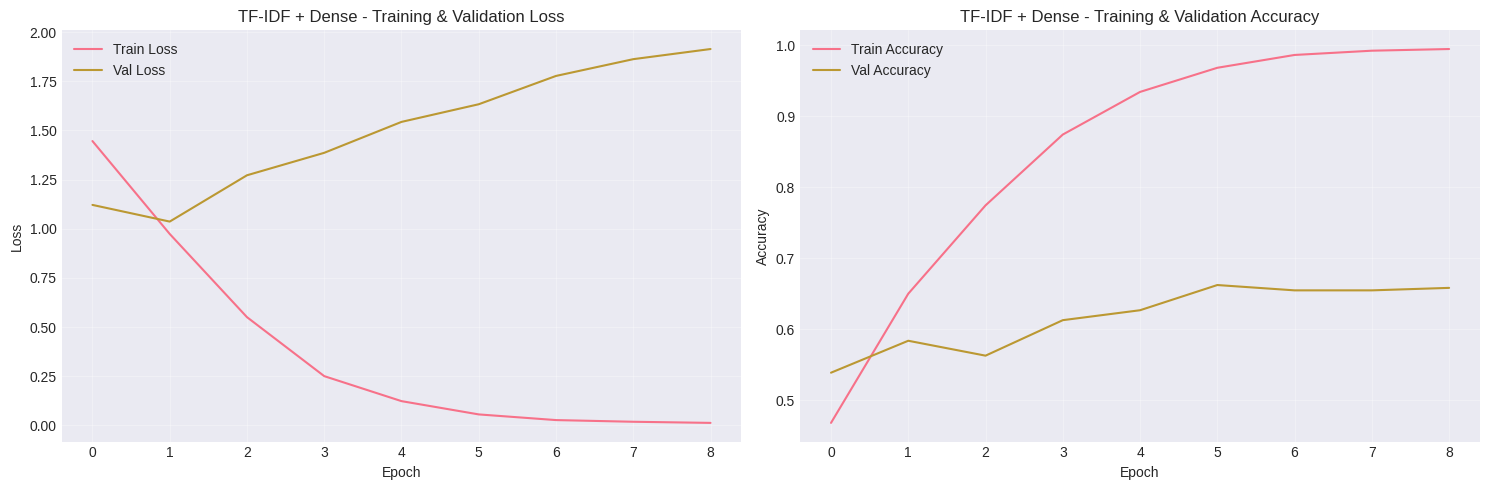

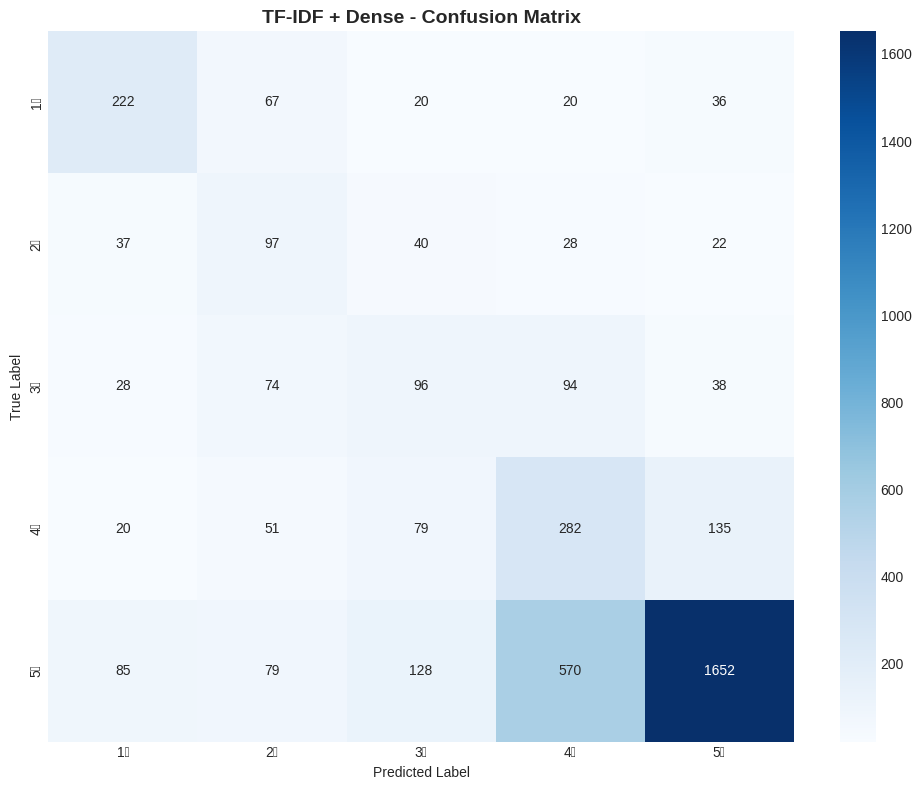


✅ Experiment logged: tfidf_20260205_131139


In [98]:
# Generate TF-IDF embeddings
from datetime import datetime
embedding_gen = EmbeddingGenerator(TRAIN_CONFIG)
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = embedding_gen.generate_tfidf(
    train_texts, val_texts, test_texts
)

# Build model
model_tfidf = build_dense_model(X_train_tfidf.shape[1], TRAIN_CONFIG)
model_tfidf.summary()

# Train model
history_tfidf, time_tfidf = train_model(
    model_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val,
    TRAIN_CONFIG, class_weight_dict, 'tfidf_dense'
)

# Evaluate
results_tfidf, y_pred_tfidf, cm_tfidf = evaluate_model(
    model_tfidf, X_test_tfidf, y_test, 'TF-IDF + Dense'
)

# Plot results
plot_training_history(history_tfidf, 'TF-IDF + Dense')
plot_confusion_matrix(cm_tfidf, 'TF-IDF + Dense')

# Log experiment
tracker.log_experiment('tfidf', TRAIN_CONFIG, history_tfidf, results_tfidf, time_tfidf)

---
# PART 3: Experiment 2 - Word2Vec CBOW + GRU

Train a GRU model with Word2Vec CBOW embeddings.


🔤 Generating Word2Vec CBOW embeddings...
  Training Word2Vec CBOW...
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3211 - loss: 1.5549

110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3217 - loss: 1.5546 - val_accuracy: 0.5310 - val_loss: 1.2457 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4707 - loss: 1.4215

110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4707 - loss: 1.4215 - val_accuracy: 0.5480 - val_loss: 1.1476 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4919 - loss: 1.3659 - val_accuracy: 0.5320 - val_loss: 1.1642 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4934 - loss: 1.3391

110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4935 - loss: 1.3392 - val_accuracy: 0.5575 - val_loss: 1.1049 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5207 - loss: 1.3085

110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5207 - loss: 1.3085 - val_accuracy: 0.5745 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5246 - loss: 1.2903

110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5246 - loss: 1.2904 - val_accuracy: 0.5925 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5285 - loss: 1.2600 - val_accuracy: 0.5140 - val_loss: 1.1691 - learning_rate: 0.0010
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5381 - loss: 1.2553 - val_accuracy: 0.5470 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5447 - loss: 1.2186
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5447 - loss: 1.2186 - val_accuracy: 0.5085 - val_loss: 1.1784 - learning_rate: 0.0010
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5415 - loss: 1.2091 - val_accuracy: 0.5440 - val_loss: 1.1125 - learning_rate: 5.0000e-04
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5528 - loss: 1.1643 - v

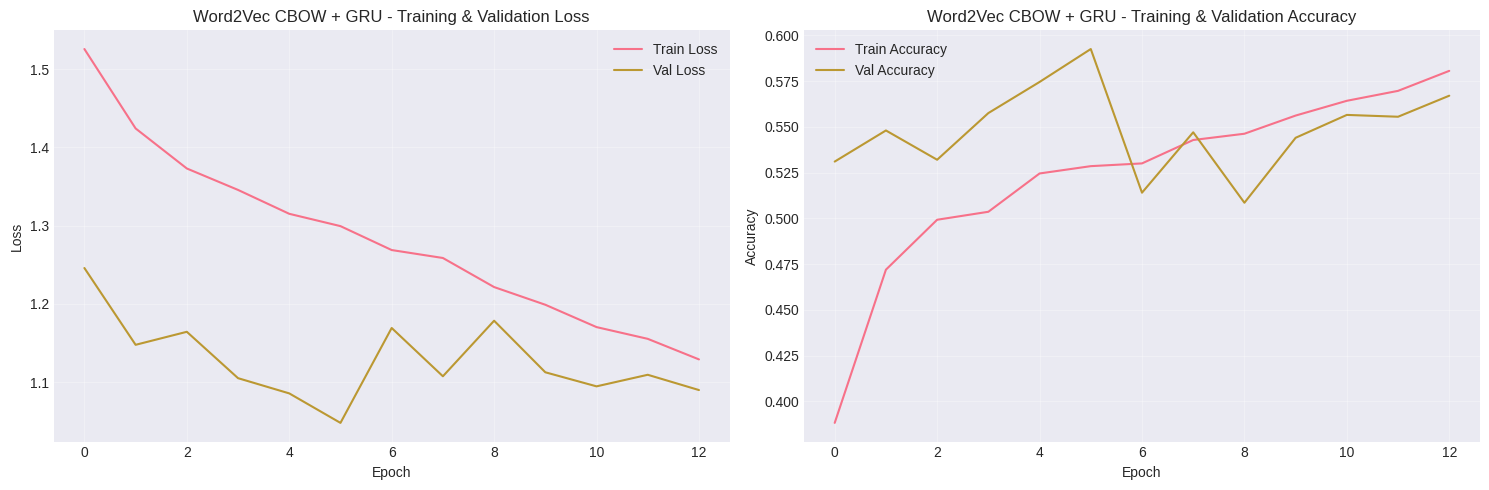

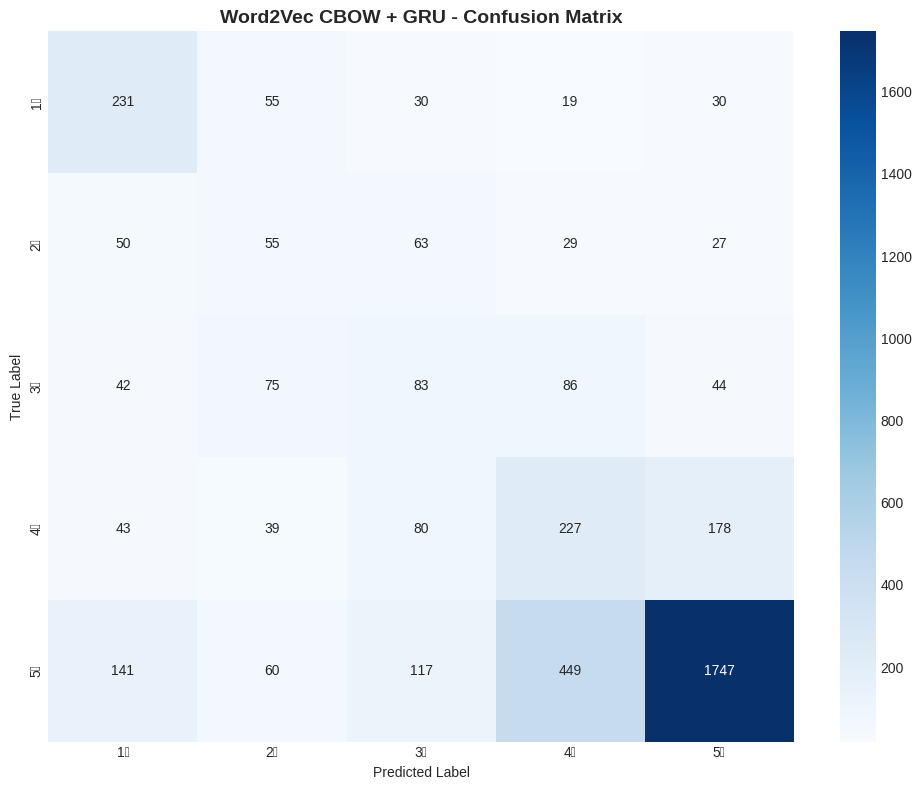


✅ Experiment logged: word2vec_cbow_20260205_133928


In [99]:
# Generate Word2Vec CBOW embeddings (sg=0)

from gensim.models import Word2Vec, FastText

def build_gru_model(vocab_size, embedding_matrix, config, trainable_embedding=False):
    """Build Bidirectional GRU model for sequence-based embeddings."""
    print("\n🏗️ Building GRU model...")
    
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=config['EMBEDDING_DIM'],
            weights=[embedding_matrix],
            input_length=config['MAX_SEQUENCE_LENGTH'],
            trainable=trainable_embedding,
            mask_zero=True
        ),
        
        # First Bidirectional GRU layer
        layers.Bidirectional(
            layers.GRU(
                config['GRU_UNITS'],
                return_sequences=True,
                dropout=config['DROPOUT_RATE'],
                recurrent_dropout=config['RECURRENT_DROPOUT']
            )
        ),
        
        # Second Bidirectional GRU layer
        layers.Bidirectional(
            layers.GRU(
                config['GRU_UNITS'],
                dropout=config['DROPOUT_RATE'],
                recurrent_dropout=config['RECURRENT_DROPOUT']
            )
        ),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(config['DROPOUT_RATE']),
        
        # Output layer
        layers.Dense(config['NUM_CLASSES'], activation='softmax')
    ])
    
    # Build the model explicitly with input shape
    model.build(input_shape=(None, config['MAX_SEQUENCE_LENGTH']))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"  Model parameters: {model.count_params():,}")
    return model

X_train_cbow, X_val_cbow, X_test_cbow, embedding_matrix_cbow, vocab_size_cbow = embedding_gen.generate_word2vec(
    train_texts, val_texts, test_texts, sg=0
)

# Build model
model_cbow = build_gru_model(vocab_size_cbow, embedding_matrix_cbow, TRAIN_CONFIG, trainable_embedding=False)
model_cbow.summary()

# Train model
history_cbow, time_cbow = train_model(
    model_cbow, X_train_cbow, y_train, X_val_cbow, y_val,
    TRAIN_CONFIG, class_weight_dict, 'word2vec_cbow_gru'
)

# Evaluate
results_cbow, y_pred_cbow, cm_cbow = evaluate_model(
    model_cbow, X_test_cbow, y_test, 'Word2Vec CBOW + GRU'
)

# Plot results
plot_training_history(history_cbow, 'Word2Vec CBOW + GRU')
plot_confusion_matrix(cm_cbow, 'Word2Vec CBOW + GRU')

# Log experiment
tracker.log_experiment('word2vec_cbow', TRAIN_CONFIG, history_cbow, results_cbow, time_cbow)

---
# PART 4: Experiment 3 - Word2Vec Skip-gram + GRU

Train a GRU model with Word2Vec Skip-gram embeddings.


🔤 Generating Word2Vec Skip-gram embeddings...
  Training Word2Vec Skip-gram...
  Vocabulary size: 13081
  Embedding dimension: 100
  Train shape: (14000, 128)
  Val shape: (2000, 128)
  Test shape: (4000, 128)

🏗️ Building GRU model...
  Model parameters: 1,601,865


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 128, 100)       │     1,308,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128, 192)       │       114,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 192)            │       167,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601,865 (6.11 MB)

 Trainable params: 293,765 (1.12 MB)

 Non-trainable params: 1,308,100 (4.99 MB)


🚀 Training word2vec_skipgram_gru...
  Epochs: 30
  Batch size: 128
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2932 - loss: 1.5765

110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2939 - loss: 1.5761 - val_accuracy: 0.5775 - val_loss: 1.2462 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4769 - loss: 1.4086 - val_accuracy: 0.5665 - val_loss: 1.1877 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4887 - loss: 1.3809 - val_accuracy: 0.5475 - val_loss: 1.1627 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5011 - loss: 1.3618 - val_accuracy: 0.4865 - val_loss: 1.2298 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5109 - loss: 1.3309 - val_accuracy: 0.5460 - val_loss: 1.1337 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5155 - loss: 1.3203 - val_accuracy: 0.5620 - val_loss: 1.1117 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5263 - loss: 1.2987 - val_

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5436 - loss: 1.2735 - val_accuracy: 0.5780 - val_loss: 1.0902 - learning_rate: 0.0010
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5590 - loss: 1.2423 - val_accuracy: 0.5645 - val_loss: 1.1194 - learning_rate: 0.0010
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5482 - loss: 1.2334 - val_accuracy: 0.5735 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5639 - loss: 1.1983 - val_accuracy: 0.5340 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 13/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5583 - loss: 1.1931 - val_accuracy: 0.5690 - val_loss: 1.1100 - learning_rate: 0.0010
Epoch 14/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5707 - loss: 1.1742
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5707 - loss: 1.1743 - v

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5798 - loss: 1.1486 - val_accuracy: 0.5865 - val_loss: 1.0763 - learning_rate: 5.0000e-04
Epoch 17/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5854 - loss: 1.1105 - val_accuracy: 0.5810 - val_loss: 1.0677 - learning_rate: 5.0000e-04
Epoch 18/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5850 - loss: 1.1154 - val_accuracy: 0.5685 - val_loss: 1.0670 - learning_rate: 5.0000e-04
Epoch 19/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5718 - loss: 1.1038 - val_accuracy: 0.5820 - val_loss: 1.0367 - learning_rate: 5.0000e-04
Epoch 20/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5834 - loss: 1.0793 - val_accuracy: 0.5485 - val_loss: 1.1013 - learning_rate: 5.0000e-04
Epoch 21/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5842 - loss: 1.0715 - val_accuracy: 0.5750 - val_loss: 1.0663 - learning_rate: 5.0000e-04
Epoch 22/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

110/110 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5992 - loss: 1.0227 - val_accuracy: 0.5950 - val_loss: 1.0426 - learning_rate: 2.5000e-04
Epoch 26/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5956 - loss: 1.0383

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5957 - loss: 1.0382 - val_accuracy: 0.5975 - val_loss: 1.0236 - learning_rate: 1.2500e-04
Epoch 27/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6016 - loss: 1.0147 - val_accuracy: 0.5885 - val_loss: 1.0486 - learning_rate: 1.2500e-04
Epoch 28/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5975 - loss: 1.0139 - val_accuracy: 0.5830 - val_loss: 1.0519 - learning_rate: 1.2500e-04
Epoch 29/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6059 - loss: 1.0164
Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6059 - loss: 1.0164 - val_accuracy: 0.5825 - val_loss: 1.0488 - learning_rate: 1.2500e-04
Epoch 30/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6039 - loss: 0.9992 - val_accuracy: 0.5865 - val_loss: 1.0505 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 26.

✅ Training 

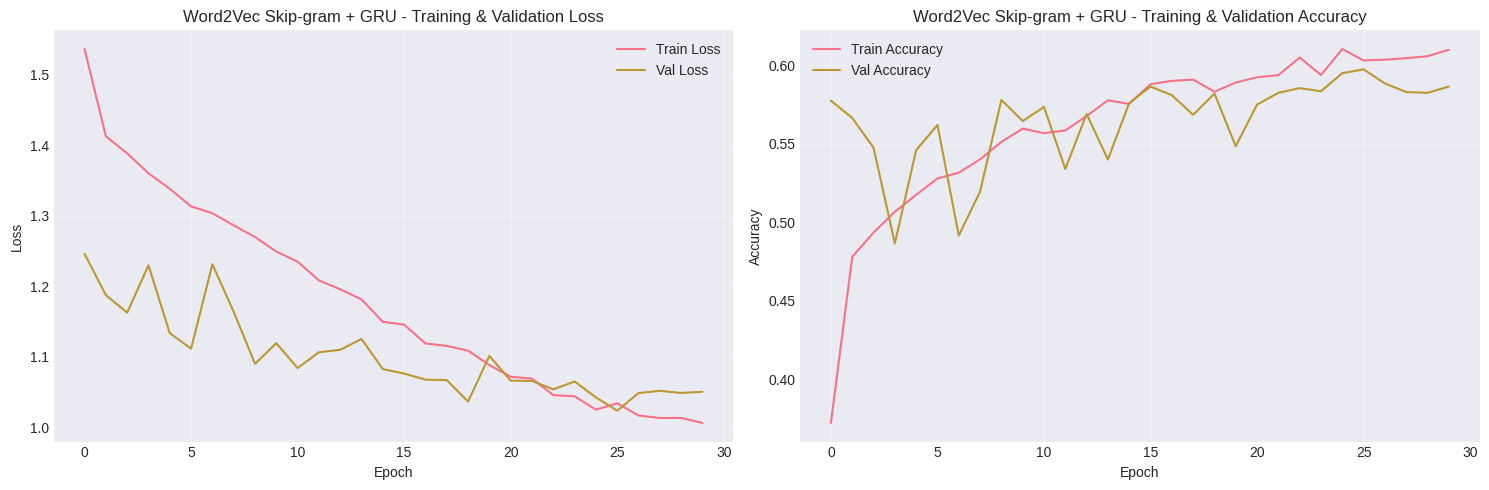

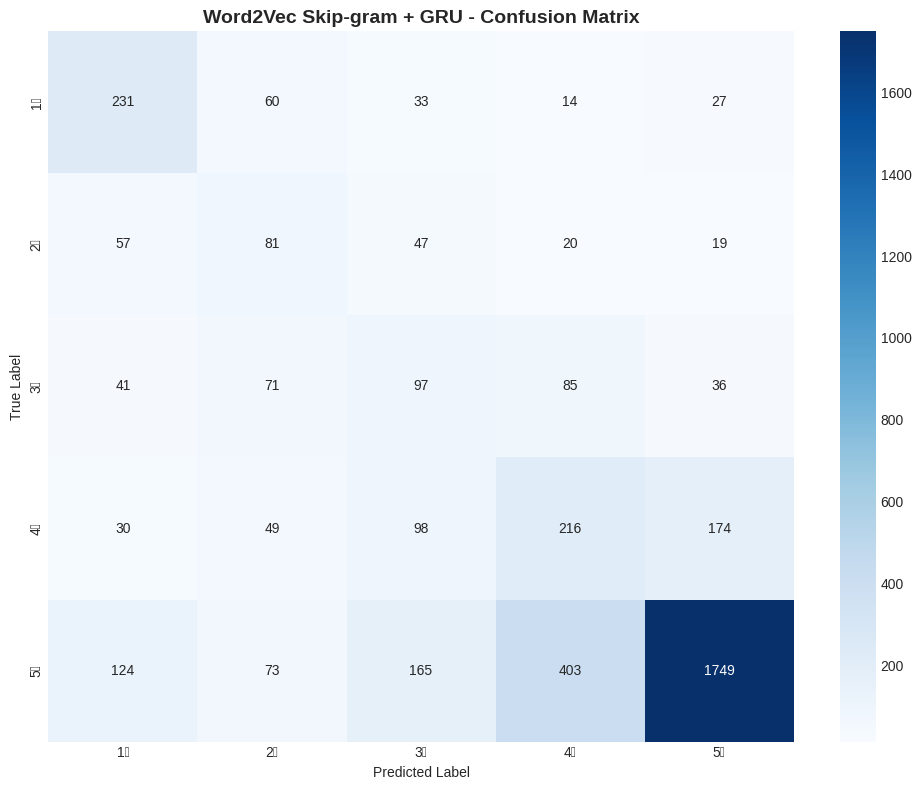


✅ Experiment logged: word2vec_skipgram_20260205_144441


In [100]:
# Generate Word2Vec Skip-gram embeddings (sg=1)
X_train_sg, X_val_sg, X_test_sg, embedding_matrix_sg, vocab_size_sg = embedding_gen.generate_word2vec(
    train_texts, val_texts, test_texts, sg=1
)

# Build model
model_sg = build_gru_model(vocab_size_sg, embedding_matrix_sg, TRAIN_CONFIG, trainable_embedding=False)
model_sg.summary()

# Train model
history_sg, time_sg = train_model(
    model_sg, X_train_sg, y_train, X_val_sg, y_val,
    TRAIN_CONFIG, class_weight_dict, 'word2vec_skipgram_gru'
)

# Evaluate
results_sg, y_pred_sg, cm_sg = evaluate_model(
    model_sg, X_test_sg, y_test, 'Word2Vec Skip-gram + GRU'
)

# Plot results
plot_training_history(history_sg, 'Word2Vec Skip-gram + GRU')
plot_confusion_matrix(cm_sg, 'Word2Vec Skip-gram + GRU')

# Log experiment
tracker.log_experiment('word2vec_skipgram', TRAIN_CONFIG, history_sg, results_sg, time_sg)

---
# PART 5: Experiment 4 (Optional) - FastText + GRU

Train a GRU model with FastText embeddings (handles subword information).


🔤 Generating FastText embeddings...
  Training FastText...
  Vocabulary size: 13081
  Embedding dimension: 100
  Train shape: (14000, 128)

🏗️ Building GRU model...
  Model parameters: 1,601,865


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 128, 100)       │     1,308,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128, 192)       │       114,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 192)            │       167,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601,865 (6.11 MB)

 Trainable params: 293,765 (1.12 MB)

 Non-trainable params: 1,308,100 (4.99 MB)


🚀 Training fasttext_gru...
  Epochs: 30
  Batch size: 128
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3055 - loss: 1.5735

110/110 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3061 - loss: 1.5732 - val_accuracy: 0.4595 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4600 - loss: 1.4168

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4600 - loss: 1.4168 - val_accuracy: 0.5115 - val_loss: 1.2750 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4838 - loss: 1.3829

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4839 - loss: 1.3830 - val_accuracy: 0.5370 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4974 - loss: 1.3642 - val_accuracy: 0.4535 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4921 - loss: 1.3477

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4922 - loss: 1.3477 - val_accuracy: 0.5390 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5104 - loss: 1.3176 - val_accuracy: 0.4745 - val_loss: 1.2682 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5255 - loss: 1.3007

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5255 - loss: 1.3007 - val_accuracy: 0.5445 - val_loss: 1.1402 - learning_rate: 0.0010
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5349 - loss: 1.2743 - val_accuracy: 0.4855 - val_loss: 1.1831 - learning_rate: 0.0010
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5367 - loss: 1.2496

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5369 - loss: 1.2496 - val_accuracy: 0.5615 - val_loss: 1.0960 - learning_rate: 0.0010
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5270 - loss: 1.2485

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5271 - loss: 1.2485 - val_accuracy: 0.5790 - val_loss: 1.0546 - learning_rate: 0.0010
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5551 - loss: 1.2078 - val_accuracy: 0.5390 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 13/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5442 - loss: 1.2069 - val_accuracy: 0.5670 - val_loss: 1.0666 - learning_rate: 0.0010
Epoch 14/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5609 - loss: 1.1792
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5609 - loss: 1.1793 - val_accuracy: 0.5435 - val_loss: 1.0736 - learning_rate: 0.0010
Epoch 15/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5568 - loss: 1.1698 - val_accuracy: 0.5635 - val_loss: 1.0782 - learning_rate: 5.0000e-04
Epoch 16/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5702 - loss: 1.1484

110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5703 - loss: 1.1484 - val_accuracy: 0.6005 - val_loss: 1.0184 - learning_rate: 5.0000e-04
Epoch 17/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5788 - loss: 1.1291 - val_accuracy: 0.5725 - val_loss: 1.0553 - learning_rate: 5.0000e-04
Epoch 18/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5714 - loss: 1.1038 - val_accuracy: 0.5825 - val_loss: 1.0376 - learning_rate: 5.0000e-04
Epoch 19/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5794 - loss: 1.1154
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5794 - loss: 1.1155 - val_accuracy: 0.5835 - val_loss: 1.0519 - learning_rate: 5.0000e-04
Epoch 20/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5740 - loss: 1.0942 - val_accuracy: 0.5695 - val_loss: 1.0777 - learning_rate: 2.5000e-04
Epoch 21/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.590

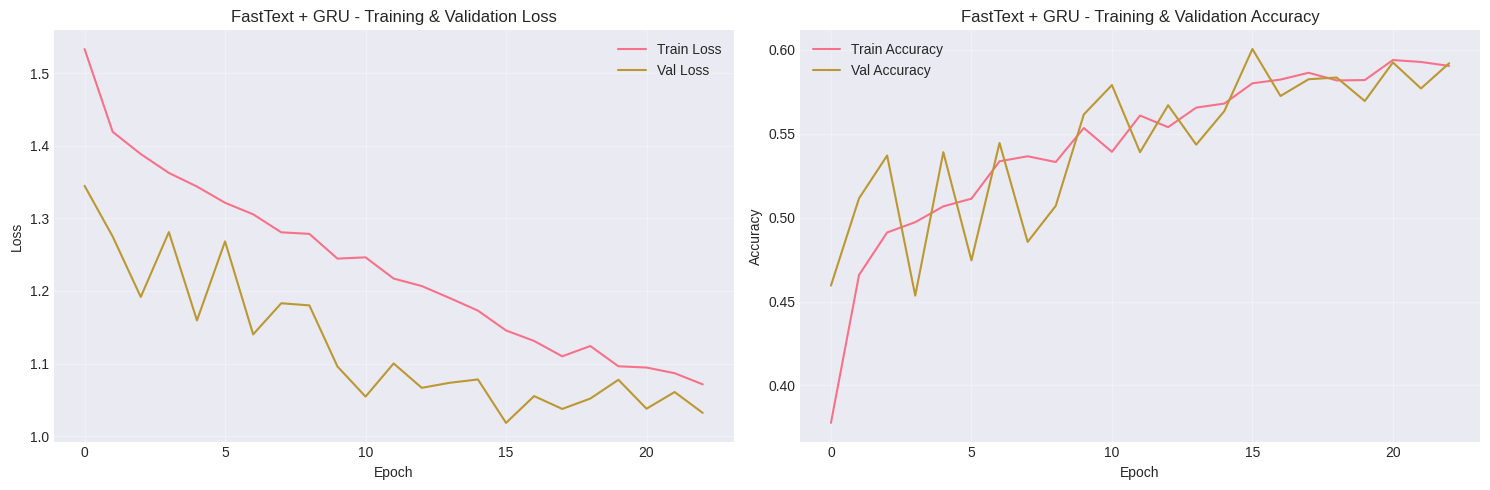

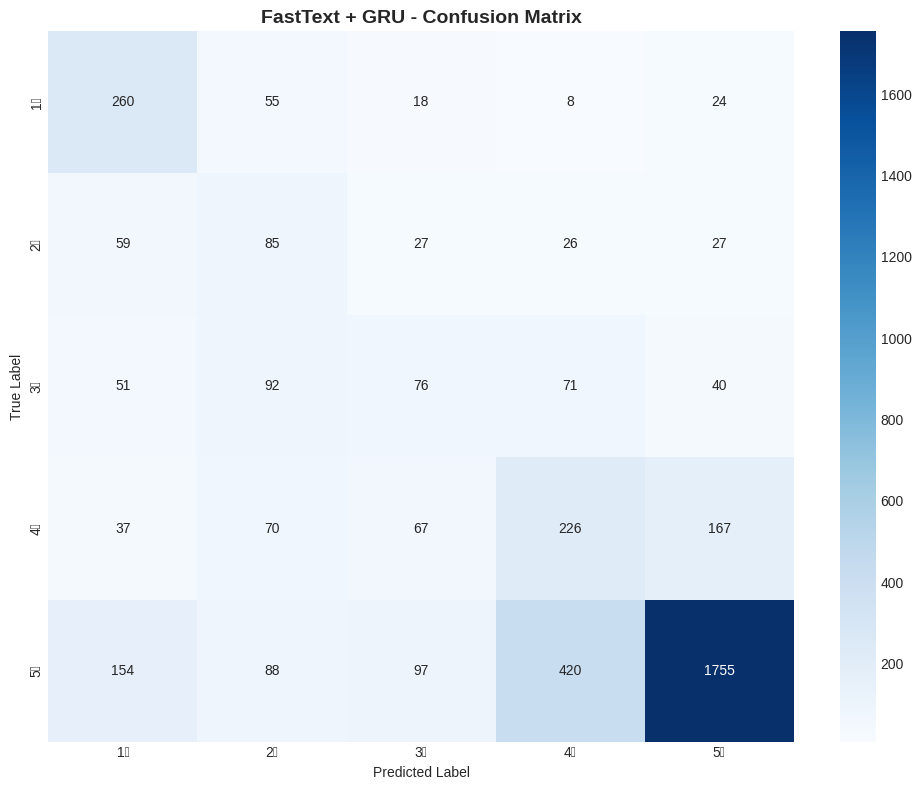


✅ Experiment logged: fasttext_20260205_153517


In [101]:
# Generate FastText embeddings
X_train_ft, X_val_ft, X_test_ft, embedding_matrix_ft, vocab_size_ft = embedding_gen.generate_fasttext(
    train_texts, val_texts, test_texts
)

# Build model
model_ft = build_gru_model(vocab_size_ft, embedding_matrix_ft, TRAIN_CONFIG, trainable_embedding=False)
model_ft.summary()

# Train model
history_ft, time_ft = train_model(
    model_ft, X_train_ft, y_train, X_val_ft, y_val,
    TRAIN_CONFIG, class_weight_dict, 'fasttext_gru'
)

# Evaluate
results_ft, y_pred_ft, cm_ft = evaluate_model(
    model_ft, X_test_ft, y_test, 'FastText + GRU'
)

# Plot results
plot_training_history(history_ft, 'FastText + GRU')
plot_confusion_matrix(cm_ft, 'FastText + GRU')

# Log experiment
tracker.log_experiment('fasttext', TRAIN_CONFIG, history_ft, results_ft, time_ft)

---
# PART 6: Comparative Analysis

Compare all trained models and summarize results.

EXPERIMENT SUMMARY
                    Experiment ID         Embedding  Accuracy  F1 (Macro)  F1 (Weighted)  Best Val Acc  Training Time (min)  Epochs
            tfidf_20260205_125246             tfidf   0.59610    0.462820       0.628904        0.6816             0.543708       7
            tfidf_20260205_131139             tfidf   0.58725    0.460803       0.618213        0.6620             0.201249       9
    word2vec_cbow_20260205_133928     word2vec_cbow   0.58575    0.416358       0.610384        0.5925            26.924600      13
word2vec_skipgram_20260205_144441 word2vec_skipgram   0.59350    0.438436       0.620182        0.5975            61.474524      30
         fasttext_20260205_153517          fasttext   0.60050    0.440775       0.623055        0.6005            46.939781      23


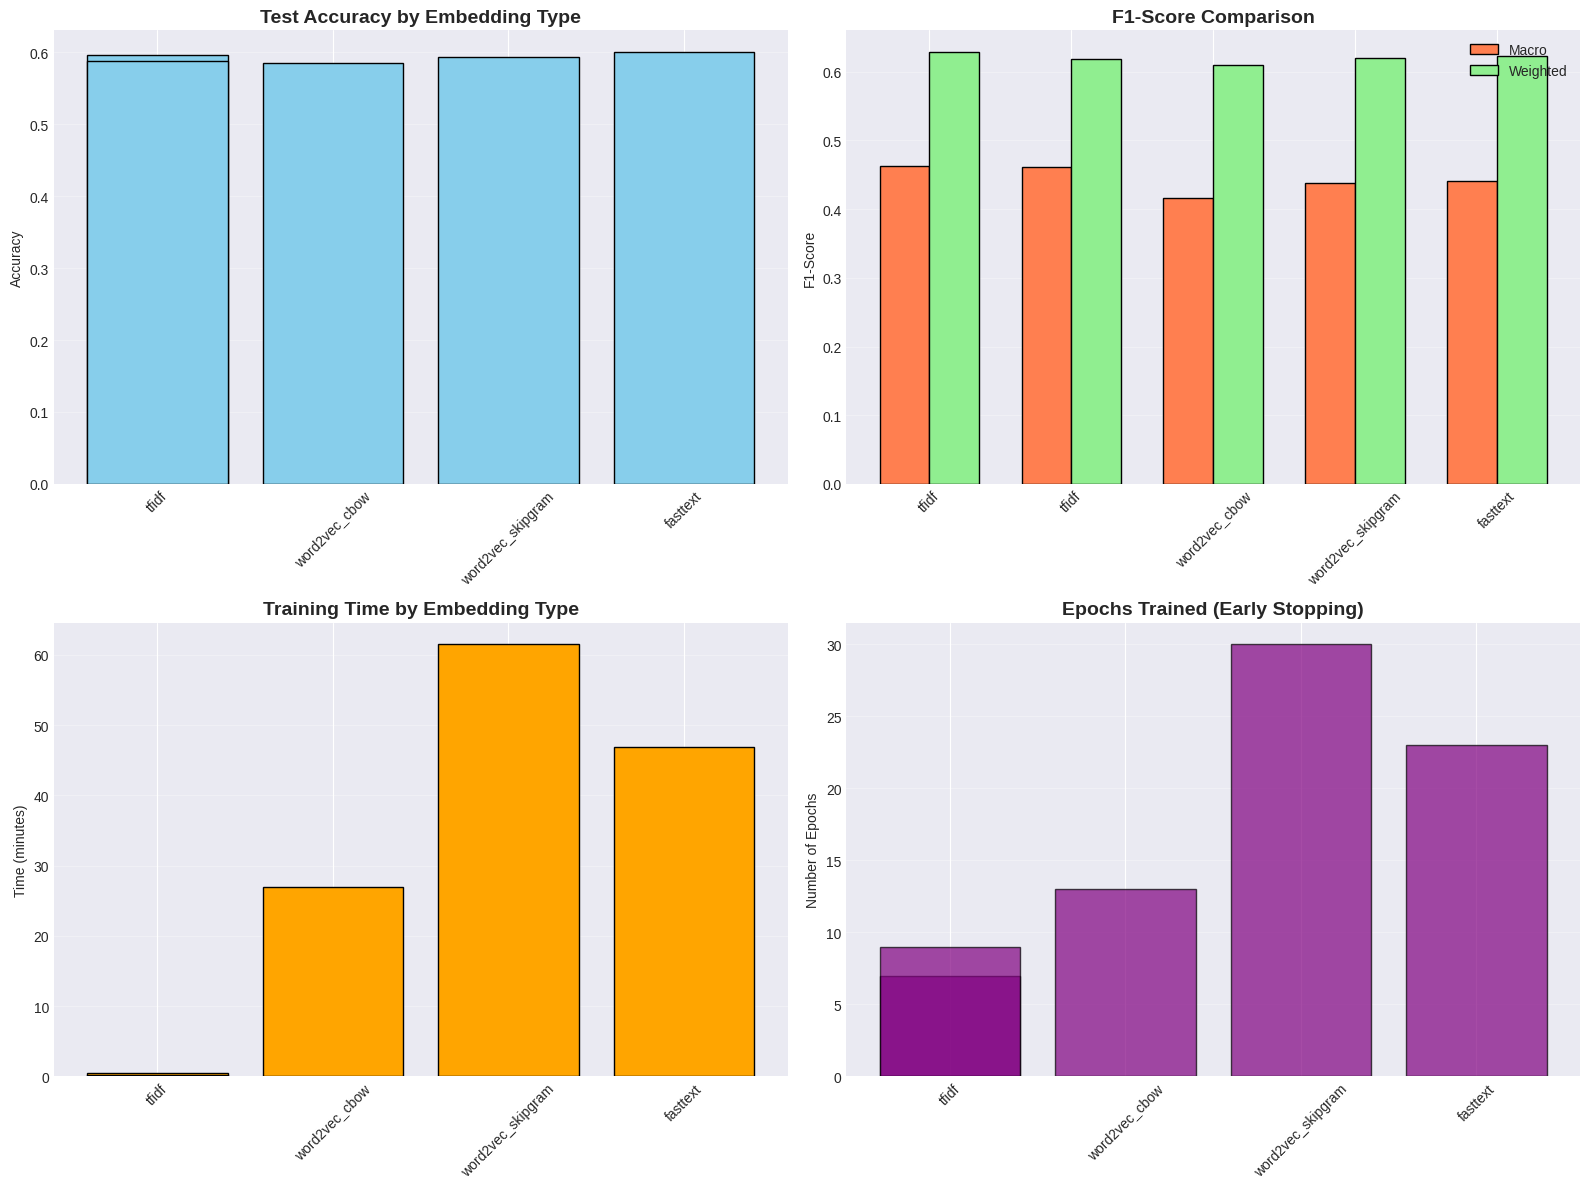


✅ Results saved to: ../results/experiment_summary.csv


In [102]:
# Display summary of all experiments
print("="*100)
print("EXPERIMENT SUMMARY")
print("="*100)

summary_df = tracker.get_summary_df()
print(summary_df.to_string(index=False))

# Generate comparison plots
tracker.compare_models()

# Save summary to CSV
summary_df.to_csv('../results/experiment_summary.csv', index=False)
print("\n✅ Results saved to: ../results/experiment_summary.csv")

---
# PART 7: Hyperparameter Tuning

Tune hyperparameters for the best performing embeddings.

In [103]:
# Define hyperparameter search space
hp_search_space = {
    'GRU_UNITS': [64, 128, 256],
    'DROPOUT_RATE': [0.3, 0.5],
    'BATCH_SIZE': [32, 64],
    'LEARNING_RATE': [0.001, 0.0001]
}

print("Hyperparameter Search Space:")
for param, values in hp_search_space.items():
    print(f"  {param}: {values}")
    
print(f"\nTotal combinations: {np.prod([len(v) for v in hp_search_space.values()])}")

Hyperparameter Search Space:
  GRU_UNITS: [64, 128, 256]
  DROPOUT_RATE: [0.3, 0.5]
  BATCH_SIZE: [32, 64]
  LEARNING_RATE: [0.001, 0.0001]

Total combinations: 24


In [104]:
def hyperparameter_tuning(embedding_type, X_train, X_val, X_test, y_train, y_val, y_test, 
                         embedding_matrix, vocab_size, hp_space, base_config, class_weights):
    """Perform hyperparameter tuning with grid search."""
    
    print(f"\n{'='*100}")
    print(f"HYPERPARAMETER TUNING: {embedding_type}")
    print(f"{'='*100}\n")
    
    best_score = 0
    best_config = None
    best_model = None
    tuning_results = []
    
    # Generate all combinations (limited to prevent excessive training time)
    from itertools import product
    
    # Sample a subset of combinations for faster tuning
    import random
    all_combinations = list(product(
        hp_space['GRU_UNITS'],
        hp_space['DROPOUT_RATE'],
        hp_space['BATCH_SIZE'],
        hp_space['LEARNING_RATE']
    ))
    
    # Select 8 random combinations (or all if fewer)
    selected_combinations = random.sample(all_combinations, min(8, len(all_combinations)))
    
    print(f"Testing {len(selected_combinations)} hyperparameter combinations...\n")
    
    for idx, (gru_units, dropout, batch_size, lr) in enumerate(selected_combinations, 1):
        print(f"\n--- Configuration {idx}/{len(selected_combinations)} ---")
        print(f"GRU Units: {gru_units}, Dropout: {dropout}, Batch Size: {batch_size}, LR: {lr}")
        
        # Create modified config
        config = base_config.copy()
        config['GRU_UNITS'] = gru_units
        config['DROPOUT_RATE'] = dropout
        config['BATCH_SIZE'] = batch_size
        config['LEARNING_RATE'] = lr
        config['EPOCHS'] = 20  # Reduced for tuning
        
        # Build model
        model = build_gru_model(vocab_size, embedding_matrix, config, trainable_embedding=False)
        
        # Train (with reduced verbosity)
        history, train_time = train_model(
            model, X_train, y_train, X_val, y_val,
            config, class_weights, f'{embedding_type}_hp_{idx}'
        )
        
        # Evaluate on validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        
        print(f"  Val Accuracy: {val_acc:.4f}")
        
        # Store results
        tuning_results.append({
            'config_id': idx,
            'gru_units': gru_units,
            'dropout_rate': dropout,
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'training_time': train_time
        })
        
        # Track best
        if val_acc > best_score:
            best_score = val_acc
            best_config = config
            best_model = model
            print(f"  ⭐ New best configuration!")
    
    # Evaluate best model on test set
    print(f"\n{'='*100}")
    print(f"BEST CONFIGURATION FOUND")
    print(f"{'='*100}")
    print(f"GRU Units: {best_config['GRU_UNITS']}")
    print(f"Dropout: {best_config['DROPOUT_RATE']}")
    print(f"Batch Size: {best_config['BATCH_SIZE']}")
    print(f"Learning Rate: {best_config['LEARNING_RATE']}")
    print(f"Best Val Accuracy: {best_score:.4f}")
    
    # Final evaluation on test set
    results, y_pred, cm = evaluate_model(best_model, X_test, y_test, f'{embedding_type}_tuned')
    
    # Save tuning results
    tuning_df = pd.DataFrame(tuning_results)
    tuning_df.to_csv(f'../results/{embedding_type}_hyperparameter_tuning.csv', index=False)
    print(f"\n✅ Tuning results saved to: ../results/{embedding_type}_hyperparameter_tuning.csv")
    
    return best_config, best_model, results, tuning_df

print("✅ Hyperparameter tuning function defined")

✅ Hyperparameter tuning function defined


In [ ]:
# Perform hyperparameter tuning on the best 2 embeddings from baseline experiments
# Note: Uncomment and run this cell to perform hyperparameter tuning
# This may take significant time depending on your hardware

# Example: Tune Word2Vec CBOW (assuming it performed well in baseline)
best_config_cbow, best_model_cbow, tuned_results_cbow, tuning_df_cbow = hyperparameter_tuning(
    embedding_type='word2vec_cbow',
    X_train=X_train_cbow,
    X_val=X_val_cbow,
    X_test=X_test_cbow,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    embedding_matrix=embedding_matrix_cbow,
    vocab_size=vocab_size_cbow,
    hp_space=hp_search_space,
    base_config=TRAIN_CONFIG,
    class_weights=class_weight_dict
)

# Example: Tune Word2Vec Skip-gram
best_config_sg, best_model_sg, tuned_results_sg, tuning_df_sg = hyperparameter_tuning(
    embedding_type='word2vec_skipgram',
    X_train=X_train_sg,
    X_val=X_val_sg,
    X_test=X_test_sg,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    embedding_matrix=embedding_matrix_sg,
    vocab_size=vocab_size_sg,
    hp_space=hp_search_space,
    base_config=TRAIN_CONFIG,
    class_weights=class_weight_dict
)

print("ℹ️ Hyperparameter tuning cell ready.")


HYPERPARAMETER TUNING: word2vec_cbow

Testing 8 hyperparameter combinations...


--- Configuration 1/8 ---
GRU Units: 256, Dropout: 0.5, Batch Size: 32, LR: 0.001

🏗️ Building GRU model...
  Model parameters: 3,073,865

🚀 Training word2vec_cbow_hp_1...
  Epochs: 20
  Batch size: 32
Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3226 - loss: 1.5955

438/438 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.3227 - loss: 1.5954 - val_accuracy: 0.4855 - val_loss: 1.3629 - learning_rate: 0.0010
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3945 - loss: 1.4992

438/438 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.3945 - loss: 1.4992 - val_accuracy: 0.5325 - val_loss: 1.3235 - learning_rate: 0.0010
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.4626 - loss: 1.4486 - val_accuracy: 0.4780 - val_loss: 1.2987 - learning_rate: 0.0010
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4570 - loss: 1.4278

438/438 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.4570 - loss: 1.4278 - val_accuracy: 0.5350 - val_loss: 1.1866 - learning_rate: 0.0010
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4747 - loss: 1.3922

438/438 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.4747 - loss: 1.3922 - val_accuracy: 0.5510 - val_loss: 1.1437 - learning_rate: 0.0010
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.4626 - loss: 1.3756 - val_accuracy: 0.5490 - val_loss: 1.1340 - learning_rate: 0.0010
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4856 - loss: 1.3565

438/438 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.4857 - loss: 1.3565 - val_accuracy: 0.5990 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.4951 - loss: 1.3223 - val_accuracy: 0.5665 - val_loss: 1.1156 - learning_rate: 0.0010
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.4809 - loss: 1.3280 - val_accuracy: 0.5460 - val_loss: 1.1294 - learning_rate: 0.0010
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4903 - loss: 1.2967
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
438/438 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.4903 - loss: 1.2967 - val_accuracy: 0.5615 - val_loss: 1.1049 - learning_rate: 0.0010
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.5025 - loss: 1.2587 - val_accuracy: 0.5700 - val_loss: 1.0644 - learning_rate: 5.0000e-04
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.5135 - loss: 1.2222 -

219/219 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.2866 - loss: 1.5835 - val_accuracy: 0.4890 - val_loss: 1.3646 - learning_rate: 1.0000e-04
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4470 - loss: 1.4680

219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.4471 - loss: 1.4680 - val_accuracy: 0.5105 - val_loss: 1.3106 - learning_rate: 1.0000e-04
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4788 - loss: 1.4210

219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4788 - loss: 1.4210 - val_accuracy: 0.5325 - val_loss: 1.2429 - learning_rate: 1.0000e-04
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4885 - loss: 1.3859

219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4885 - loss: 1.3860 - val_accuracy: 0.5430 - val_loss: 1.2116 - learning_rate: 1.0000e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5012 - loss: 1.3615

219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5012 - loss: 1.3615 - val_accuracy: 0.5470 - val_loss: 1.2040 - learning_rate: 1.0000e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5020 - loss: 1.3528 - val_accuracy: 0.5465 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4977 - loss: 1.3414

219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.4977 - loss: 1.3415 - val_accuracy: 0.5710 - val_loss: 1.1352 - learning_rate: 1.0000e-04
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5101 - loss: 1.3331 - val_accuracy: 0.5485 - val_loss: 1.1576 - learning_rate: 1.0000e-04
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5101 - loss: 1.3110 - val_accuracy: 0.5680 - val_loss: 1.1225 - learning_rate: 1.0000e-04
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5140 - loss: 1.3033 - val_accuracy: 0.5645 - val_loss: 1.1311 - learning_rate: 1.0000e-04
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5237 - loss: 1.2936 - val_accuracy: 0.5700 - val_loss: 1.1195 - learning_rate: 1.0000e-04
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5229 - loss: 1.2762 - val_accuracy: 0.5630 - val_loss: 1.1170 - learning_rate: 1.0000e-04
Epoch 13/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 

219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5331 - loss: 1.2372 - val_accuracy: 0.5715 - val_loss: 1.0943 - learning_rate: 1.0000e-04
Epoch 17/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5431 - loss: 1.2311 - val_accuracy: 0.5600 - val_loss: 1.1066 - learning_rate: 1.0000e-04
Epoch 18/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.5345 - loss: 1.2228 - val_accuracy: 0.5600 - val_loss: 1.1016 - learning_rate: 1.0000e-04
Epoch 19/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5526 - loss: 1.1945
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5526 - loss: 1.1945 - val_accuracy: 0.5690 - val_loss: 1.1000 - learning_rate: 1.0000e-04
Epoch 20/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5427 - loss: 1.1965 - val_accuracy: 0.5685 - val_loss: 1.0902 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 20.

✅ Training

219/219 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.3963 - loss: 1.5433 - val_accuracy: 0.5385 - val_loss: 1.1899 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.4800 - loss: 1.4090 - val_accuracy: 0.5050 - val_loss: 1.3007 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4999 - loss: 1.3654 - val_accuracy: 0.5275 - val_loss: 1.2106 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5255 - loss: 1.3282
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5255 - loss: 1.3283 - val_accuracy: 0.4855 - val_loss: 1.2379 - learning_rate: 0.0010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5231 - loss: 1.2839 - val_accuracy: 0.5190 - val_loss: 1.1595 - learning_rate: 5.0000e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5374 - loss: 1.2275 - val

219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5364 - loss: 1.2101 - val_accuracy: 0.5500 - val_loss: 1.1224 - learning_rate: 5.0000e-04
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5567 - loss: 1.1589 - val_accuracy: 0.5345 - val_loss: 1.1355 - learning_rate: 5.0000e-04
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.5618 - loss: 1.1228 - val_accuracy: 0.5490 - val_loss: 1.1054 - learning_rate: 5.0000e-04
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5784 - loss: 1.0847 - val_accuracy: 0.5320 - val_loss: 1.1220 - learning_rate: 5.0000e-04
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5818 - loss: 1.0249

219/219 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5818 - loss: 1.0249 - val_accuracy: 0.5725 - val_loss: 1.0955 - learning_rate: 5.0000e-04
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.5964 - loss: 0.9891 - val_accuracy: 0.5355 - val_loss: 1.1890 - learning_rate: 5.0000e-04
Epoch 13/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6137 - loss: 0.9175 - val_accuracy: 0.5480 - val_loss: 1.1664 - learning_rate: 5.0000e-04
Epoch 14/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6212 - loss: 0.8643
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.6212 - loss: 0.8644 - val_accuracy: 0.5730 - val_loss: 1.1561 - learning_rate: 5.0000e-04
Epoch 15/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6434 - loss: 0.7879 - val_accuracy: 0.5700 - val_loss: 1.1655 - learning_rate: 2.5000e-04
Epoch 16/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6689 - loss: 0.7116

219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6690 - loss: 0.7116 - val_accuracy: 0.5765 - val_loss: 1.1673 - learning_rate: 2.5000e-04
Epoch 17/20
  7/219 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - accuracy: 0.6933 - loss: 0.6208

---
# Final Summary & Next Steps

## What We've Accomplished:

1. ✅ **Exploratory Data Analysis** - Analyzed Amazon Food Reviews dataset
2. ✅ **Data Preprocessing** - Built comprehensive text preprocessing pipeline
3. ✅ **Multiple Embeddings** - Implemented TF-IDF, Word2Vec (CBOW & Skip-gram), and FastText
4. ✅ **GRU Models** - Built and trained Bidirectional GRU models
5. ✅ **Systematic Tracking** - Logged all experiments with metrics and visualizations
6. ✅ **Hyperparameter Tuning** - Framework ready for optimization

## Key Files Generated:

- `models/*.h5` - Trained model weights
- `results/experiments.json` - Complete experiment log
- `results/experiment_summary.csv` - Summary table
- `results/plots/*.png` - All visualization plots
- `results/*_hyperparameter_tuning.csv` - Tuning results

## Next Steps:

1. **Review Baseline Results** - Analyze which embedding performed best
2. **Run Hyperparameter Tuning** - Optimize the best 2 embeddings
3. **Academic Report** - Document findings, methodology, and results
4. **Additional Experiments** - Try GloVe pre-trained embeddings if needed
5. **Error Analysis** - Examine misclassified examples to understand model limitations

## Notes for Academic Report:

- Compare embeddings based on accuracy, F1-score (macro/weighted), training time
- Discuss impact of class imbalance and class weights
- Analyze per-class performance (which ratings are harder to predict?)
- Consider computational efficiency vs. performance trade-offs
- Reference papers on Word2Vec, FastText, and GRU architectures

## Traditional ML: Logistic Regression with TF-IDF

A baseline classification model leveraging TF-IDF vectorization and Logistic Regression to establish performance benchmarks for multi-class sentiment analysis.

**Key Components:**
- Text preprocessing (cleaning, tokenization, lemmatization)
- TF-IDF feature extraction
- Multi-class logistic regression classifier

**Author:** Carine Ahishakiye

Text preprocessing

In [ ]:
print("TEXT PREPROCESSING")

def preprocess_text(text):
    """Clean and preprocess text."""
    if pd.isna(text):
        return ""

    text = BeautifulSoup(str(text), "html.parser").get_text()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words and len(w) >= 2]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return ' '.join(tokens)

# Preprocess all texts
print("\nPreprocessing texts...")
df['cleaned_text'] = [preprocess_text(text) for text in tqdm(df['Text'])]

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f" Cleaned {len(df):,} reviews")

# Show example
print("\n Example:")
print(f"Original: {df['Text'].iloc[0][:150]}...")
print(f"Cleaned:  {df['cleaned_text'].iloc[0][:150]}...")

### Text Preprocessing

Transforms raw review text into clean, standardized format through a multi-step pipeline: removes HTML tags and URLs, converts to lowercase, eliminates special characters and punctuation, tokenizes into individual words, filters out common stopwords, applies lemmatization to reduce words to their base forms, and removes empty entries to ensure high-quality input data for downstream modeling.

In [ ]:
print("TRAIN-TEST SPLIT")

# Preparing data
X = df['cleaned_text'].values
y = df['Score'].values - 1  # Convert 1-5 to 0-4

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Train: {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test:  {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# Check class distribution
print("\n Class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} (★{cls+1}): {count:,} ({count/len(y_train)*100:.1f}%)")

### Train-Test Split

Partitions the dataset into training (80%) and testing (20%) subsets using stratified sampling to maintain balanced class distributions across both sets, with scores normalized from 1-5 scale to 0-4 for model compatibility.

In [ ]:
print("TF-IDF VECTORIZATION")

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"Feature dimensions: {X_train_tfidf.shape[1]}")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape:  {X_test_tfidf.shape}")

# Show sample features
feature_names = tfidf.get_feature_names_out()
print(f"\n Sample features: {list(feature_names[:15])}")

### TF-IDF Vectorization

Converts cleaned text into numerical feature vectors using Term Frequency-Inverse Document Frequency with a maximum of 5,000 features, capturing both unigrams and bigrams while filtering out terms that appear in less than 2 documents or more than 95% of documents to reduce noise and dimensionality.

In [ ]:
print("TRAINING LOGISTIC REGRESSION")

model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Model Configuration:")
print(f"  C (regularization): {model.C}")
print(f"  Max iterations: {model.max_iter}")
print(f"  Class weight: {model.class_weight}")
print(f"  Solver: {model.solver}")

start_time = time.time()
model.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time

print(f"\n Training complete: {training_time:.2f}s ({training_time/60:.2f} min)")


### Model Training

Trains a Logistic Regression classifier with L2 regularization (C=1.0), balanced class weights to handle class imbalance, and parallel processing for efficient computation across multiple cores.

In [ ]:
print("EVALUATION")

# Predictions
y_pred = model.predict(X_test_tfidf)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, zero_division=0
)

# Macro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro', zero_division=0
)

# Weighted averages
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted', zero_division=0
)

# Print results
print("\nOverall Metrics:")
print(f"Accuracy:              {accuracy:.4f}")
print(f"Precision (Macro):     {precision_macro:.4f}")
print(f"Recall (Macro):        {recall_macro:.4f}")
print(f"F1-Score (Macro):      {f1_macro:.4f}")
print(f"Precision (Weighted):  {precision_weighted:.4f}")
print(f"Recall (Weighted):     {recall_weighted:.4f}")
print(f"F1-Score (Weighted):   {f1_weighted:.4f}")

print("\n Per-Class Metrics:")
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)
for i in range(5):
    print(f"★{i+1} (Class {i})  {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")


### Model Evaluation

Assesses classifier performance using multiple metrics including overall accuracy, per-class precision, recall, and F1-scores, with both macro-averaged (equal class importance) and weighted-averaged (proportional to class size) results to provide comprehensive evaluation across all sentiment categories.

In [ ]:
print("CONFUSION MATRIX")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Ploting
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['1★', '2★', '3★', '4★', '5★'],
    yticklabels=['1★', '2★', '3★', '4★', '5★'],
    cbar_kws={'label': 'Count'}
)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('True Rating', fontsize=12)
plt.tight_layout()
plt.show()

### Confusion Matrix

Visualizes model prediction accuracy across all rating categories through a heatmap displaying true versus predicted class distributions, enabling identification of classification patterns and common misclassification trends between adjacent rating scores.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.25

ax.bar(x - width, precision, width, label='Precision', color='skyblue', edgecolor='black')
ax.bar(x, recall, width, label='Recall', color='lightcoral', edgecolor='black')
ax.bar(x + width, f1, width, label='F1-Score', color='lightgreen', edgecolor='black')

ax.set_xlabel('Rating Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression - Per-Class Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Add value labels
for i in range(5):
    ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}',
            ha='center', va='bottom', fontsize=9)
    ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}',
            ha='center', va='bottom', fontsize=9)
    ax.text(i + width, f1[i] + 0.02, f'{f1[i]:.2f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
try:
    with open('/content/drive/MyDrive/Grp 15 ML techniques/lr_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    with open('/content/drive/MyDrive/Grp 15 ML techniques/tfidf.pkl', 'wb') as f:
        pickle.dump(tfidf, f)

    print(" Models saved to Google Drive")
except:
    print(" Could not save to Google Drive. Saving to Colab runtime instead.")
    with open('lr_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    with open('tfidf.pkl', 'wb') as f:
        pickle.dump(tfidf, f)
    print(" Models saved to Colab runtime")
